# Input data and import modules
## Here we input the directory for all the results of the Fiji plugin Comdet v0.5.5 and the _seg.py files, See the MAIN CODE below for more details


In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from cellpose import plot, utils
import statistics as s 
import sys, os
import pandas as pd
import math
import copy
from matplotlib.ticker import PercentFormatter

#-------------------INPUT THE DIRECTORIES HERE---------:
#Directory for the output "Results" from the "particle_detection" script for FIJI

directory_res = "/Users/ceciliaacosta/Downloads/Images_to_seg_2/Images/particles_result/"

#Directory for the output of CELLPOSE segmentation masks in which you put _seg.py files only

directory_seg="/Users/ceciliaacosta/Downloads/Images_to_seg_2/Segmentations/"
#This iterate over files in directory_res and put it in a list 


files=[]
for filename in os.listdir(directory_res):
    f = os.path.join(directory_res, filename)
    if not filename.endswith(".DS_Store"):
        files.append(f)

files.sort()


#------------ This creates the folders where the results will be stored -------------

folder_path = './Tables'  # Replace with your desired folder path
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

fig_path = './Figures'  # Replace with your desired folder path
if not os.path.exists(fig_path):
    os.makedirs(fig_path)


### This deletes all the segmentation files from the channel that does not have good segmentation
### Careful just run it ONCE! 
### Don't run this if you have phase-contrast segmentation

In [18]:

folder_path = "/Users/ceciliaacosta/Downloads/data ceci/1rst dt/seg/"  # Replace with the path to your folder
files_2 = os.listdir(folder_path)
files_2.sort() 

for i, file in enumerate(files_2):
    if i % 2 == 0: #Keep the even numbered files (removes 1, 3, 5, etc...)  # 

        os.remove(os.path.join(folder_path, file))

directory_seg="/Users/ceciliaacosta/Downloads/data ceci/1rst dt/seg/"


Here 15 28


# Functions 


## point_in_poly: Point polygon algorithm
- INPUT: the outlines of each mask as vertices and the pixel coordinate (X,Y) at the center of the particle detection.
- OUTPUT: True if inside, False if outside

## cell_length: Get the cell lenght
- INPUT: An array/list of coordinates that define the outline of a cell
- OUTPUT: Two variables: - The length of the cell, - The coordinate at the center of the cell 

In [2]:
def point_in_poly(x, y, poly):
    # Check if a point (x,y) is inside a polygon defined by a set of vertices 
  
    n = len(poly)
    inside = False

    p1x, p1y = poly[0]
    
    for i in range(1, n + 1):
        p2x, p2y = poly[i % n]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xints = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    if p1x == p2x or x <= xints:
                        inside = not inside
        p1x, p1y = p2x, p2y

    return inside

def cell_lenght(outline):
    #---initialize the min, max values of the coordinates of the outline of one cell
    maxx= float('-inf')
    maxy= float('-inf')
    minx= float('inf')
    miny= float('inf')

#--This for loop finds the max and min value for x and y coordinates: maxx= max (x) pixel coord, minx= min (x) pixel coord, maxy= max (y) pixel coord, miny= "" ""
    for i in range (len(outline)):

        x=outline[i][0]
        y=outline[i][1]
        
        if x>maxx:
            maxx=x
        if y>maxy:
            maxy=y
        if y<miny:
            miny=y
        if x<minx:
            minx=x

    lenght=math.sqrt((maxx-minx)**2+(maxy-miny)**2) # Find the lenght using the Pythagoras formula
    center_coordinate= [minx+(maxx-minx)/2, miny+(maxy-miny)/2]    # Find the approximate center of the cell

    return lenght, center_coordinate


## Function to create a Table to be able to do data analysis
- INPUT: fiji file in a readable form, the outlines of the cell from the _seg.npy segmentation file from cellpose, x: the size of the pixel
- It outputs a table where we have the relative distance of a particle to its corresponding cell center, and many other datas. It creates a table that will be saved and outputed in the MAIN CODE and also outputs the counts per cell in an image that will be used to create the histogram of counts per cell for a channel. 

In [5]:
def table_creation(data, outlines, size, min): 

#-----------Initialization of variables -----------
    counts= np.empty(0, dtype=int)   #The number of particles per cell 
    table= np.zeros((1000, 10)) #the final table with 10 columns and 1000 rows (1000 is arbitrary to not cause error)
    count= 0
    one= []    #one ,two , ... are lists that will contain the counts for each different classes of cell lenght chosen
    two= []
    three= []
    four= []
    rel_dist= []
    z= 0       #this var 
    coloc= {}
    cellnum=1


    #-----------create tables
    for i in range (len(outlines)):
        poly=outlines[i]
        lenght, center= cell_lenght(poly)
        if lenght>min :

            count=0

            for j in range ( len(data)):
    #MAKE SURE TO FIRST OPEN THE RESULTS DATA TO SEE HOW THE COLUMNS WERE SAVED (sometimes FIJI saves the results with one extra empty column at the beginning)
                x=data[j][1]   #CHANGE THIS SO THE COLUMN IS ALIGNED WITH X_(px)
                y=data[j][2]    #CHANGE THIS SO THE COLUMN IS ALIGNED WITH Y_(px)
                coord=[x,y]
                
                if point_in_poly(x,y,poly): #if particle inside the cell segmentation
        
                    distance= math.sqrt((y-center[1])**2+(x-center[0])**2)
                    rel_dist.append(distance/(lenght/2))

                    count+=1
            
                    table[z][0]=i
                    table[z][1]=count 
                    table[z][3]=lenght
                    table[z][4]=x
                    table[z][5]=y
                    table[z][6]=data[j][11] ##CHANGE THIS SO THE COLUMN IS ALIGNED IntegratedInt
                    table[z][7]=center[0]
                    table[z][8]=center[1]
                    table[z][9]=distance

                    if cellnum not in coloc:

                        coloc[cellnum]=[]
                        coloc[cellnum].append(coord)
                    
                    else:

                        coloc[cellnum].append(coord)
                
                    z+=1

            counts=np.append(counts,count)
            #print(cellnum, count)
            if (count==0):
                table[z][0]=i
                table[z][3]=lenght
                table[z][7]=center[0]
                table[z][8]=center[1] #the rest of the columns will be 0     
                coloc[cellnum]=[]

                z+=1
                            
            else:
                y=z
                for w in range (0,count):
                    table[y-1][2]=count
                    y-=1
            
            cellnum+=1
            
            #-----------change variable "function" to True or False depending if you want histograms for each diff cell size------

            function=True

            if (function):

                nanometer= size*lenght

                if (nanometer>=2000 and nanometer<=2800):
                    one.append(count)
                elif (nanometer> 2800 and nanometer<=3600):
                    two.append(count)
                elif (nanometer> 3600 and nanometer<=4400):
                    three.append(count)
                elif (nanometer> 4400):
                    four.append(count)
                else:
                    continue 
        else:
            continue

    average=s.mean(counts)

    return table, counts, average, one, two, three, four, coloc, rel_dist, cellnum

## Functions for histograms

In [6]:
def counts_histogram(total_1, total_2):

    global fig_path
    if total_2.size==0:
        fig=plt.figure()
        bins1=np.arange(0,int(np.max(total_1)), 1)
        ax = fig.add_subplot(111)
        ax.hist(total_1, weights=np.ones(len(total_1)) / len(total_1),  alpha=0.6,label="channel 1,  n="+str(sum(total_1)), ec="black", rwidth = 0.5,  bins=bins1-0.5, facecolor='yellow')
        #ax.hist(total_2, weights=np.ones(len(total_2)) / len(total_2), alpha=0.75, ec="black", label="channel 2,  n="+str(sum(total_2)), rwidth = 0.5,  bins=bins1-0.25, facecolor='red')
        plt.xticks(bins1)
        
        ax.set_title("Particles per cell for each channel")
        ax.set_xlabel('Particles per cell')
        ax.set_ylabel('Percentage for each channel')
        
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        plt.legend(loc="upper right")
        plt.savefig(str(fig_path)+'/Counts.png')

    else:

        fig=plt.figure()
        bins1=np.arange(0,int(max(np.max(total_1), np.max(total_2))), 1)
        ax = fig.add_subplot(111)
        ax.hist(total_1, weights=np.ones(len(total_1)) / len(total_1),  alpha=0.6,label="channel 1,  n="+str(sum(total_1)), ec="black", rwidth = 0.5,  bins=bins1-0.5, facecolor='yellow')
        ax.hist(total_2, weights=np.ones(len(total_2)) / len(total_2), alpha=0.75, ec="black", label="channel 2,  n="+str(sum(total_2)), rwidth = 0.5,  bins=bins1-0.25, facecolor='red')
        plt.xticks(bins1)
        
        ax.set_title("Particles per cell for each channel")
        ax.set_xlabel('Particles per cell')
        ax.set_ylabel('Percentage for each channel')
        
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        plt.legend(loc="upper right")
        plt.savefig(str(fig_path)+'/Counts.png')


def size_histogram(one, two, three, four, chan, total):

    global fig_path
    fig=plt.figure()
    bins1=np.arange(6)
    ax = fig.add_subplot(111)
    ax.hist(one, weights=np.ones(len(one)) / len(total),  alpha=0.6, label='2 ≤size< 2.8'+', n=' +str(len(one)), ec="black", rwidth = 0.2,  bins=bins1-0.8, facecolor='yellow')
    ax.hist(two, weights=np.ones(len(two)) / len(total), alpha=0.75, label='2.8 ≤size< 3.6'+', n=' +str(len(two)), ec="black", rwidth = 0.2,  bins=bins1-0.60, facecolor='red')
    ax.hist(three, weights=np.ones(len(three)) / len(total),  alpha=0.6, label='3.6 ≤size< 4.4'+', n=' +str(len(three)), ec="black", rwidth = 0.2,  bins=bins1-0.40, facecolor='blue')
    ax.hist(four, weights=np.ones(len(four)) / len(total), alpha=0.75, label='4.4 ≤size'+', n='+str(len(four)), ec="black", rwidth = 0.2,  bins=bins1-0.20, facecolor='green')
    
    ax.set_title("Particle per cell for different cell sizes for channel:"+str(chan))
    ax.set_xlabel('Particles per cell')
    ax.set_ylabel('Proportion of particles')
    plt.legend(fontsize='small')
    plt.xticks(bins1)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.legend(loc="upper right")
    plt.savefig(str(fig_path)+"/"+str(chan)+'Cell_size.png')


def coloc_histogram(data, tot_channel, title, pix, channel):

    global fig_path
    total=sum(tot_channel)
    fig, ax = plt.subplots()
    print("There is "+str(total)+" particles for the channel: " + str(channel))
    x_axis=[]
    for size in data.keys():
      
        x_axis.append(size*pix)


    bars=ax.bar(x_axis, [j/total for j in data.values()], label='n='+ str(total)+''+ str(channel),  ec="black", width = 10)

    # set the y-axis limit
    ax.set_ylim(0, 1)
    # set the x-axis label
    ax.set_xlabel('Max distance in nanometers')
    # set the y-axis label
    ax.set_ylabel('Colocalization rate')
    # set the title
    ax.set_title(str(title))

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

    plt.xticks(x_axis)
    
    plt.legend(loc="upper right")
    plt.savefig(str(fig_path)+'/Coloc.png')
    plt.show()

def distance_histogram(data, total, channel):

    global fig_path
    fig, ax = plt.subplots()
    bin_width= 1/40
    bin_edges= np.arange(0, 0.51, bin_width)
    hist, edges= np.histogram(data/2, bins=bin_edges)

# plot the data as a bar chart
    plt.bar(edges[:-1], hist, width=bin_width, align='edge', label='n='+ str(sum(total)), ec="black")

    # set the y-axis limit
    ax.set_xlim(0, 0.5)
    # set the x-axis label
    ax.set_xlabel('Absolute relative distance to the center')
    # set the y-axis label
    ax.set_ylabel('Quantity of particles')
    # set the title
    ax.set_title("Histogram of the relative distance of particles\n from the cell center for Channel: "+str(channel))

    # for bar in bars:
    #     height = bar.get_height()
    #     ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

    #plt.xticks(x_axis)
    #plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

    plt.legend(loc="upper right")
    # show the plot
    plt.savefig(str(fig_path)+"/"+str(channel)+'Distance.png')
    plt.show()

## Functions for colocalization within segmentations

### allowed_dist: 
- Evaluates if the two particles are within the allowed colocalization distance
### colocalization:
- INPUT: **Input_Chan**, **Other_chan**: The Dictionnaries for each channel, where the keys of the dictionnaries are the cell ID's and the values are the coordinates of the particles. 
**pixel_distance**: In our code we want to test the allowed distance of colocalization in pixels, but we will later convert it in nanometers

- OUTPUT: 
**Result**: It is the total number of colocalizations between Input channel and Output channel

In [7]:
def allowed_dist (cell1, cell2, maxcol_dist):
    dist= math.sqrt((cell1[0]-cell2[0])**2+(cell1[1]-cell2[1])**2)
    if (dist>maxcol_dist):

        return False, dist
    else: 
        return True, dist


def colocalization(Input_chan, other_chan, pixel_dist):
    result=0
    boo=False
    candidate=float('inf')

    for key1 in Input_chan.keys(): #iterates through all the cells of the image 

        if len(Input_chan[key1])==0: #if the cell chosen chanel has no particle go to next cell
            continue

        elif len(other_chan[key1])==0: #if the cell other chanel has no particle return result=0 
            continue         
        
        else: 
         
            for j in range(0, len(Input_chan[key1])):
                smallest_dist=float('inf')
                
                for y in range (0, len(other_chan[key1])): 
                    allowed, dist= allowed_dist(Input_chan[key1][j], other_chan[key1][y], pixel_dist )

                    if allowed and dist<=smallest_dist:
                        smallest_dist=dist
                        candidate=y
                        boo=True
                    else:
                        continue     
                if boo:
                    del other_chan[key1][candidate]
                    result+=1
                boo=False
                
    return result


## This is where we do the integrated intensity of the cells for all images Violin plot, but later we will add it to the tables for each channel 

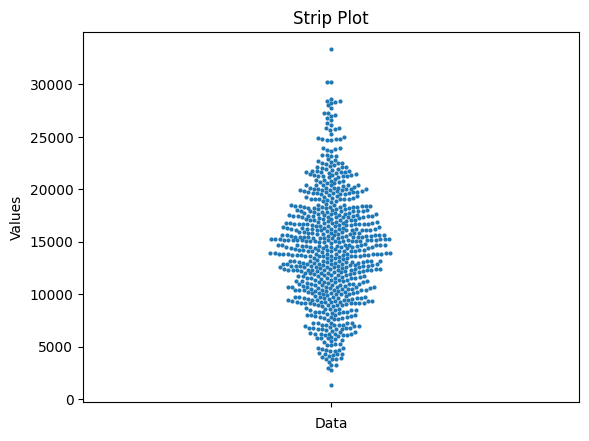

In [5]:
folder_integrated="/Users/ceciliaacosta/Desktop/data_Viri/FIJI/train+model_Viri/integrated/IntDensity"

import seaborn as sns 
# This iterate over files in directory_res and put it in a list 

files=[]
for filename in os.listdir(folder_integrated):
    f = os.path.join(folder_integrated, filename)
    if not filename.endswith(".DS_Store"):
        files.append(f)

files.sort()
IntDen=[]
for m in range(len(files)): 
    
    file_int= np.genfromtxt(files[m], delimiter=',', skip_header=1)
    for n in range (len(file_int)): 
        IntDen.append(file_int[n][4])

sns.swarmplot(data=IntDen, size=3)
plt.xlabel('Data')
plt.ylabel('Values')
plt.title('Strip Plot')
plt.savefig(str(fig_path)+"/"+'IntDen_violinplot.png')
plt.show()


   

# MAIN CODE (choose either CODE 1 if you only have two channel or CODE 2 if you have one channels)

## CODE 1 

### Variable definitions:

- **total_1** and **total_2**: Are lists for each channel where we have the COUNT of particule for each cells for ALL images. We use these variables to create the histogram
- **fiji_2** and **fiji_2** : Input variable, represents the Results output from the ComDet v.0.5.5 Detect particles Fiji Plugin. It is important to retrieve the Integrated Intensity of the particle and the pixel coordinates.
    - When the  is a .txt file, use the delimiter='\t'. When it is a .csv file use delimiter=','

- **outlines** : Important input variable for this script: we take this variable from the _seg.py files created by CELLPOSE output after segmentation. We can use the segmentation of the best color channel instead of segmentating twice the same image (but diff channel).

### Specifications: 

- In this case, each segmentation **_seg.py** file chosen from img of a single color channel will cover Particle Detection Results for BOTH channels. This is to avoid bias of segmentation that could be different for each channel.

_rrl472_coloc__03_seg.npy
_rrl472_coloc__05_seg.npy
_rrl472_coloc__07_seg.npy
_rrl472_coloc__09_seg.npy
_rrl472_coloc__11_seg.npy
_rrl472_coloc__13_seg.npy
_rrl472_coloc__15_seg.npy
_rrl472_coloc__17_seg.npy
_rrl472_coloc__19_seg.npy
There is 1700.0 particles for the channel: 1


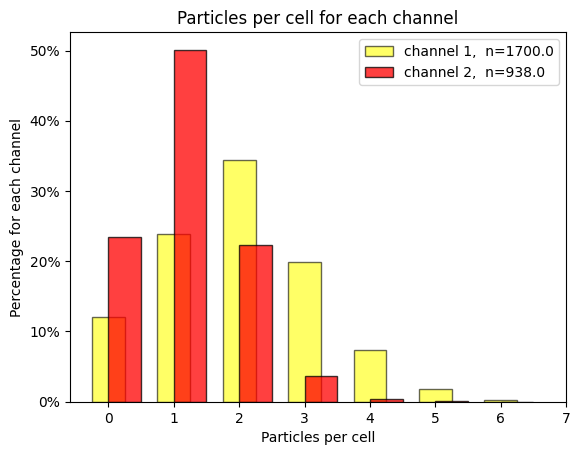

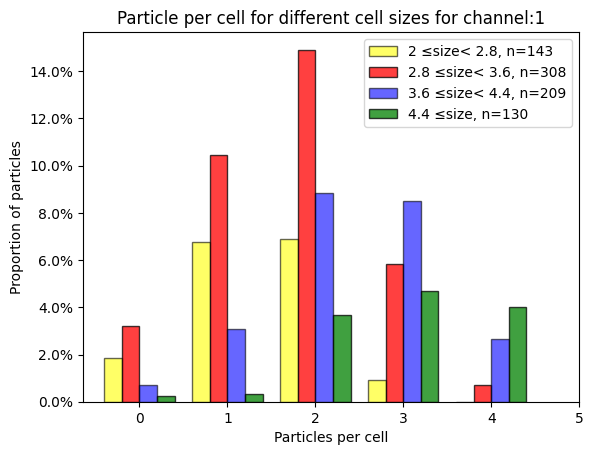

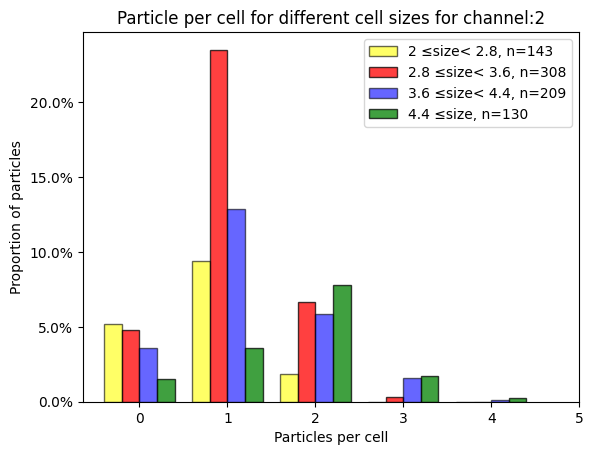

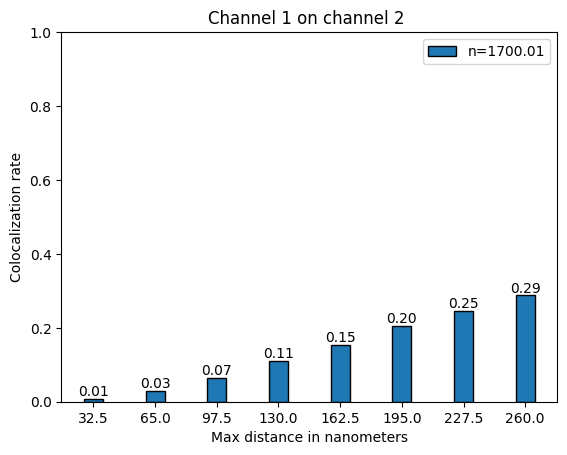

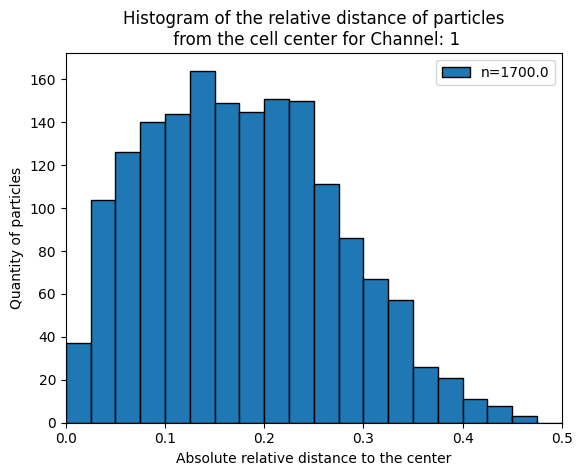

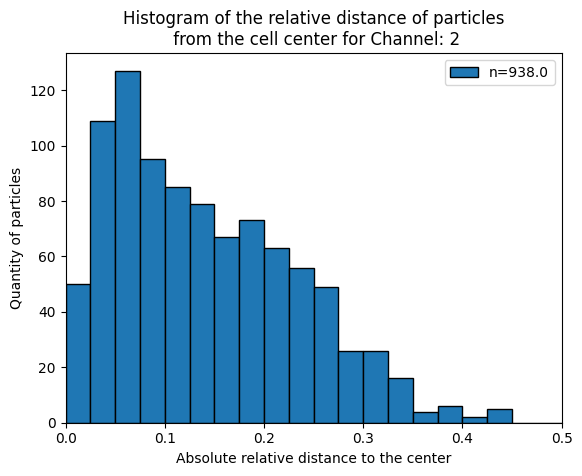

In [8]:
pixel= int(input("What is the pixel size in nanometer? Input a number:"))
channel=int(input("which chanel do you want for colocalizaton? Input either 1 or 2:"))
too_small=float(input("What is the minimum cell lenght in pixels allowed? Enter a float or integer:"))

names=['cell_id', 'part_id','total_count','cell_lenght', 'Part_X_(px)', 'Part_Y_(px)', 'IntegatedIntensity', 'Cellcenter_X(px)', 'Cellcenter_Y(px)', 'Distance']

#------ #total particles for each channel --------------------------------------------------------------------------------------------------------------------------------------------
total_1=np.empty(0) 
total_2=np.empty(0)

#------ Variables to make the histogram for particles per cell size------------------------------------------------------------------------------------------------------------------
tot_1=np.empty(0) #for channel 1 divided in cell size
tot_2=np.empty(0)
tot_3=np.empty(0) 
tot_4=np.empty(0)
tot_1_2=np.empty(0) #for channel 2 divided in cell
tot_2_2=np.empty(0)
tot_3_2=np.empty(0)
tot_4_2=np.empty(0) 

#------Variable to make the histogram of colocalization rate per distance size in pixels----------------------------------------------------------------------------------------------
new_dict = {0.5:0, 1.0:0, 1.5:0, 2:0, 2.5:0, 3:0, 3.5:0, 4:0 }
dist1=np.empty(0)
dist2=np.empty(0)


i=0
for filename in sorted(os.listdir(directory_seg)):
 
    if not filename.endswith(".DS_Store"):
        print(filename)
    
        seg_file = os.path.join(directory_seg, filename)
        seg_masks=np.load(seg_file, allow_pickle=True).item()
        masks=seg_masks['masks']
        outlines= utils.outlines_list(seg_masks['masks'])
        n=len(outlines)


        fiji_1= np.genfromtxt(files[2*i], delimiter='\t', skip_header=1)   # input channel 1 CHANGE COMMA OR TAB IF NEEDED
        fiji_2= np.genfromtxt(files[2*i+1], delimiter='\t', skip_header=1) # input channel 2 CHANGE COMMA OR TAB IF NEEDED 
        i+=1

        table_1, counts_1, average_1, one, two, three, four, coloc, distance, cellnum1=table_creation(fiji_1, outlines,pixel, too_small)
 
        table_2, counts_2, average_2, one2, two2, three2, four2, coloc2, distance2, cellnum2 =table_creation(fiji_2, outlines,pixel, too_small)  # channel 2


    #------------------# of particle per cell histogram for both channel -------------

        total_1 =np.concatenate((total_1, counts_1), axis=None) 
        total_2 =np.concatenate((total_2, counts_2), axis=None)

    #--------------------PARTICLE PER CELL SIZE HISTOGRAM-----------------------------
        tot_1=np.concatenate((tot_1, one), axis=None) 
        tot_2=np.concatenate((tot_2, two), axis=None) 
        tot_3=np.concatenate((tot_3, three), axis=None) 
        tot_4=np.concatenate((tot_4, four), axis=None) 

        tot_1_2=np.concatenate((tot_1_2, one2), axis=None) 
        tot_2_2=np.concatenate((tot_2_2, two2), axis=None) 
        tot_3_2=np.concatenate((tot_3_2, three2), axis=None) 
        tot_4_2=np.concatenate((tot_4_2, four2), axis=None) 

        dist1=np.concatenate((dist1,distance),  axis=None)
        dist2=np.concatenate((dist2,distance2),  axis=None)

    #-----------------Saving results of tables created here in CSV file ---------------

        df1 = pd.DataFrame(table_1, columns=names)
        file_path = os.path.join(folder_path, 'First_channel'+str(i)+'.csv')
        df1.to_csv(file_path, index=True, header=True, sep=',')
        df2 = pd.DataFrame(table_2, columns=names)
        file_path = os.path.join(folder_path, 'Second_channel'+str(i)+'.csv')
        df2.to_csv(file_path, index=True, header=True, sep=',')
    #----------------- COLOCALIZATION

        for key in new_dict.keys():

            inco=copy.deepcopy(coloc)
            othco=copy.deepcopy(coloc2)
            #print(othco)
            rate=colocalization(inco, othco, key)
            new_dict[key]+=rate 


#--------------Plot the histrogram of counts per cell
counts_histogram (total_1, total_2)

#--------------Plot histogram for each size of cell
size_histogram (tot_1, tot_2, tot_3, tot_4, 1, total_1)
size_histogram (tot_1_2, tot_2_2, tot_3_2, tot_4_2, 2, total_2)
    
# #-------------Plot histogram for colocalization
if channel==1:
    coloc_histogram(new_dict,total_1, "Channel 1 on channel 2 ", pixel, channel)
else:
    coloc_histogram(new_dict,total_2, "Channel 2 on channel 1", pixel, channel)

distance_histogram(dist1, total_1, 1)
distance_histogram(dist2, total_2, 2)


## CODE 2 

### Variable definitions:

- **total** LIST where we have the COUNT of particule for each cells for ALL images. We use these variables to create the histogram
- **fiji_file** Input variable, represents the Results output from the ComDet v.0.5.5 Detect particles Fiji Plugin. It is important to retrieve the Integrated Intensity of the particle and the pixel coordinates.
    - When the  is a .txt file, use the delimiter='\t'. When it is a .csv file use delimiter=','

- **outlines** : Important input variable for this script: we take this variable from the _seg.py files created by CELLPOSE output after segmentation. We can use the segmentation of the best color channel instead of segmentating twice the same image (but diff channel).

_PR23mypet_4h-1_02_seg.npy
_PR23mypet_4h-1_04_seg.npy
_PR23mypet_4h-1_08_seg.npy
_PR23mypet_4h-1_10_seg.npy


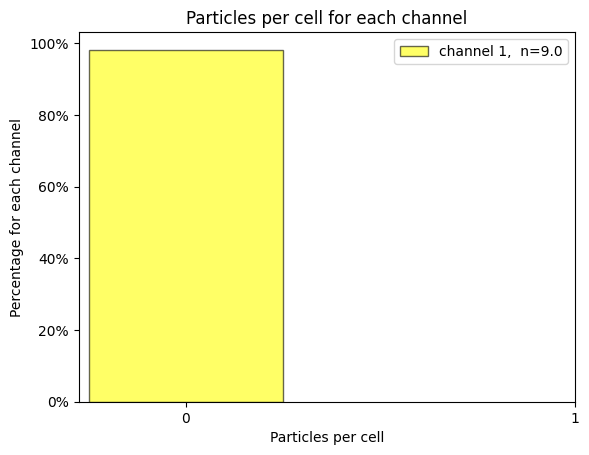

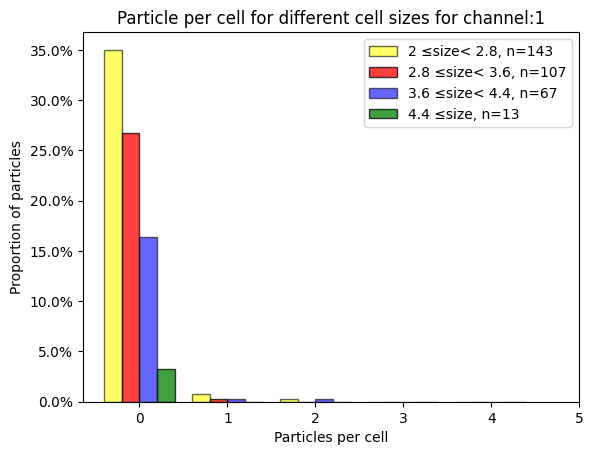

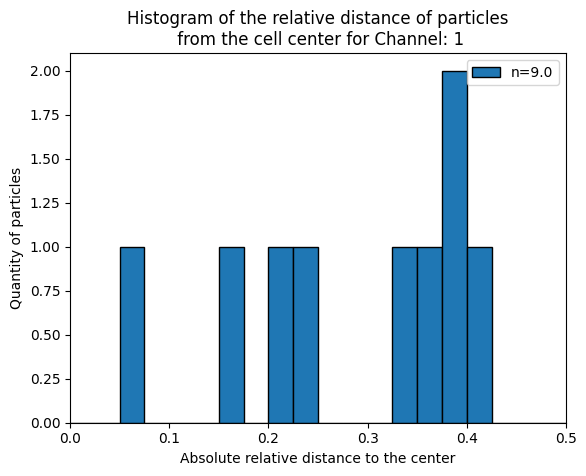

In [32]:
pixel= int(input("What is the pixel size in nanometer? Input a number:"))
too_small=float(input("What is the minimum cell lenght from the segmentation data allowed? Please enter an number:"))

names=['cell_id', 'part_id','total_count','cell_lenght', 'Part_X_(px)', 'Part_Y_(px)', 'IntegatedIntensity', 'Cellcenter_X(px)', 'Cellcenter_Y(px)', 'Distance']

#------ #total particles for each channel --------------------------------------------------------------------------------------------------------------------------------------------
total_1=np.empty(0)
total_2=np.empty(0)

#------ Variables to make the histogram for particles per cell size------------------------------------------------------------------------------------------------------------------
tot_1=np.empty(0) #for channel 1 divided in cell size
tot_2=np.empty(0)
tot_3=np.empty(0) 
tot_4=np.empty(0)

#------Variable to make the histogram of colocalization rate per distance size in pixels----------------------------------------------------------------------------------------------

dist1=np.empty(0)

i=0
for filename in sorted(os.listdir(directory_seg)):
 
    if not filename.endswith(".DS_Store"):
        print(filename)
    
        seg_file = os.path.join(directory_seg, filename)
        seg_masks=np.load(seg_file, allow_pickle=True).item()
        masks=seg_masks['masks']
        outlines= utils.outlines_list(seg_masks['masks'])
        n=len(outlines)


        fiji_1= np.genfromtxt(files[i], delimiter='\t', skip_header=1)   # input channel 1

        i+=1

        table_1, counts_1, average_1, one, two, three, four, coloc, distance, cellnum1=table_creation(fiji_1, outlines,pixel, too_small)


    #------------------num of particle per cell histogram dataset-------------

        total_1 =np.concatenate((total_1, counts_1), axis=None) 
      
    #--------------------particle per cell size dataset-----------------------------

        tot_1=np.concatenate((tot_1, one), axis=None) 
        tot_2=np.concatenate((tot_2, two), axis=None) 
        tot_3=np.concatenate((tot_3, three), axis=None) 
        tot_4=np.concatenate((tot_4, four), axis=None) 

    #--------------distance from the center dataset--------------
        dist1=np.concatenate((dist1,distance),  axis=None)

    #-----------------Saving results of tables created here in CSV file ---------------
        df1 = pd.DataFrame(table_1, columns=names)
        file_path = os.path.join(folder_path, 'table'+str(i)+'.csv')
        df1.to_csv(file_path, index=True, header=True, sep=',')
    
#--------------Plot the histrogram of counts per cell--------------
counts_histogram (total_1, total_2)

#--------------Plot histogram for each size of cell--------------
size_histogram (tot_1, tot_2, tot_3, tot_4, 1, total_1)
    
#------------Plot histogram for relative distance from the cell center--------------

distance_histogram(dist1, total_1, 1)



# Colocalization code that does not take into account if particles are in the same segmentation/ outline for both files 
- It only takes as arguments both result files for particle detection

1258 180
There is 180.0 particles for the channel: 2


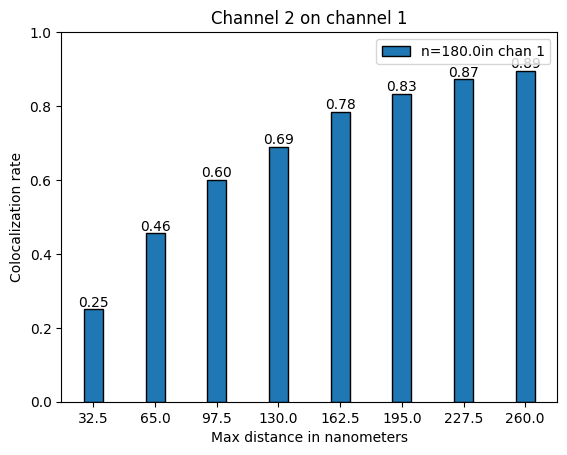

In [17]:
pixel= int(input("What is the pixel size in nanometer? Input a number:"))
channel=int(input("which chanel do you want for colocalizaton? Input either 1 or 2:"))
def coloc_data(data): 
#-----------Initialization of variables -----------
    coloc=[]
            
    for j in range ( 0, len(data)):
        coloc.append((data[j][1],data[j][2]))
        
    return coloc

def col_new(coltry, coltry2, dis):
    smallest_dist=float('inf')
    result=0
    boo=False
    candidate=float('inf')
    
    for i in range (0, len(coltry)):
        smallest_dist=float('inf')
        
        for j in range (0, len(coltry2)):
            allowed, dist= allowed_dist(coltry[i], coltry2[j] , dis)

            if allowed and dist<=smallest_dist:
                smallest_dist=dist
                candidate=j
                boo=True
    
            else:
                continue

        if boo: 
            del coltry2[candidate]
            result+=1
            
        boo=False

    return result

i=0
all_part1=0
all_part2=0

#------Variable to make the histogram of colocalization rate per distance size in pixel------
new_d = {0.5:0, 1.0:0, 1.5:0, 2:0, 2.5:0, 3:0, 3.5:0, 4:0}
for ind in range(len(files)//2):

    fiji_1= np.genfromtxt(files[2*i], delimiter= '\t', skip_header=1)   # input channel 1
    fiji_2= np.genfromtxt(files[2*i+1], delimiter= '\t', skip_header=1) # input channel 2

    coltry= coloc_data(fiji_1)
    coltry2= coloc_data(fiji_2)

    all_part1+=len(coltry)
    all_part2+=len(coltry2)

    for key in new_d.keys():
        inco=copy.deepcopy(coltry)
        othco=copy.deepcopy(coltry2)
        rate=col_new(inco, othco, key)
        new_d[key]+=rate
    
    i+=1
        
# #-------------Plot histogram for colocalization
print(all_part1, all_part2)
if channel==1:
    title="Channel 1 on channel 2"
    coloc_histogram(new_d,np.ones(all_part1), title, pixel , channel)
else:
    title="Channel 2 on channel 1"
    coloc_histogram(new_d,np.ones(all_part2), title, pixel, channel)